In [1]:
import pandas as pd
import numpy as np
from geopy.distance import distance
from tqdm import tqdm
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl

# load data

In [2]:
path = "./modeldata/gowalla/"
train_data = pd.read_csv(path+"train_data.csv",
                         parse_dates=['time'], infer_datetime_format=True)
test_data = pd.read_csv(path+"test_data.csv",
                        parse_dates=['time'], infer_datetime_format=True)
test_data

,user,time,latitude,longitude,location,region,time_delta,dist_delta
0,6138,2010-09-04 19:06:46,30.528386,-97.810511,39965,9v6mw,0.0,0.00
1,6138,2010-09-08 14:16:54,30.454928,-97.795663,1412780,9v6mq,328208.0,8267.49
2,6138,2010-09-12 22:04:41,30.335013,-97.706323,2020206,9v6s8,373667.0,15825.25
3,6138,2010-09-14 15:14:46,30.407691,-97.713379,26919,9v6sb,148205.0,8085.58
4,6138,2010-09-14 15:14:59,30.407769,-97.713478,667822,9v6sb,13.0,12.88
...,...,...,...,...,...,...,...,...
16459,90112,2010-08-01 19:43:04,30.286428,-97.741806,419988,9v6kr,325.0,81.35
16460,90112,2010-08-01 19:43:14,30.286082,-97.741901,10532,9v6kr,10.0,39.49
16461,90112,2010-08-01 20:37:34,30.270734,-97.753703,9241,9v6kp,3260.0,2045.54
16462,90112,2010-09-12 21:04:31,30.270734,-97.753703,9241,9v6kp,3630417.0,0.00


In [3]:
import random
import pickle

# get poi_embedding vector, word2idx, idx2word
loc_embedding = np.load(path+'locationembedding.npy')
_,POI_vec_dim = loc_embedding.shape
print(loc_embedding.shape)
print("POI_vec_dim = ",POI_vec_dim)

with open(path+'locationidx2node.pickle', 'rb') as f:
    loc_idx2node = pickle.load(f)
print(len(loc_idx2node))
with open(path+'locationnode2idx.pickle', 'rb') as f:
    loc_node2idx = pickle.load(f)

num_POI = len(loc_node2idx)
print(num_POI)


(21932, 100)
POI_vec_dim =  100
16054
16054


In [4]:
# get region_embedding vector, word2idx, idx2word

reg_embedding = np.load(path+'regionembedding.npy')
_,region_vec_dim = reg_embedding.shape
print(reg_embedding.shape)
print("region_vec_dim = ",region_vec_dim)

with open(path+'regionidx2node.pickle', 'rb') as f:
    reg_idx2node = pickle.load(f)
print(len(reg_idx2node))
with open(path+'regionnode2idx.pickle', 'rb') as f:
    reg_node2idx = pickle.load(f)
print(len(reg_node2idx))

(594, 50)
region_vec_dim =  50
594
594


In [5]:
# get matrix of weight
dist_matrix = np.load(path+"dist_matrix.npy")
print(dist_matrix[3])
visit_matrix = np.load(path+"visit_matrix.npy")
print(visit_matrix.shape)

[0.2182179  0.2182179  0.21952853 0.         0.10976426 0.10783277
 0.10910895 0.23094012 0.10846522 0.10910895 0.1118034  0.
 0.1118034  0.22792114 0.10783277 0.         0.         0.10976427
 0.11547006 0.10721125 0.1118034  0.         0.         0.
 0.         0.         0.         0.10783277 0.         0.
 0.10846523 0.         0.         0.1125088  0.         0.
 0.         0.11111111 0.11547006 0.         0.         0.
 0.         0.10910895 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.1125088  0.
 0.         0.         0.         0.         0.         0.
 0.         0.10783277 0.2264554  0.         0.         0.10910895
 0.         0.         0.         0.         0.         0.
 0.         0.         0.22501759 0.         0.         0.
 0.11952286 0.         0.         0.         0.         0.
 0.11952286 0.         0.         0.         0.         0.
 0.2264554  0.         0.       

# GCN module

In [6]:
%%time
# get graphs
from graphbuild import build_graph
dist_graph = build_graph(dist_matrix)
visit_graph = build_graph(visit_matrix)

print(dist_graph)
print(visit_graph)
print(dist_graph.edata['ew'][2])
print(visit_graph.edata['ew'][2])
# use torch.float32 in the whole model
print(dist_graph.device)

Graph(num_nodes=594, num_edges=16202,
      ndata_schemes={}
      edata_schemes={'ew': Scheme(shape=(1,), dtype=torch.float16)})
Graph(num_nodes=594, num_edges=12738,
      ndata_schemes={}
      edata_schemes={'ew': Scheme(shape=(1,), dtype=torch.float16)})
tensor([0.2222], dtype=torch.float16)
tensor([0.0815], dtype=torch.float16)
cpu
Wall time: 652 ms


In [7]:
# graph convolution
from dgl.nn.pytorch import GATConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_g, out_g, hid_dim, num_layers, pred_len):
        super(GCN, self).__init__()
        self.in_feats = in_feats
        self.hidden_g = hidden_g
        self.out_g = out_g
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        self.pred_len = pred_len
        self.conv1 = GATConv(in_feats = self.in_feats,
                               out_feats = self.hidden_g,
                               num_heads =1,
                              activation=nn.ReLU())
        self.conv2 = GATConv(in_feats = self.hidden_g,
                               out_feats = self.hidden_g,
                               num_heads =1,
                              activation=nn.ReLU())
        self.conv3 = GATConv(in_feats = self.hidden_g,
                               out_feats = self.out_g,
                               num_heads =1,
                              activation=nn.Tanh())
        self.GRU = nn.GRU(input_size = self.out_g*self.pred_len,
                          hidden_size = self.hid_dim,
                          num_layers = num_layers)
    def forward(self, g, nodes_vec, inputs,device):
        """
        g: graph
        nodes_vec: (node_num, in_feats);feature vector of each region, as well as region_embedding
        inputs: (seq_len, batch, pred_len);sequence of train region(id)
        """
        h = self.conv1(g, nodes_vec)
        h = self.conv2(g, h)
        h = self.conv3(g, h)
        # h:[node_num, out_g]
        a,b,c = inputs.shape
        inputs = inputs.reshape(-1, c).long()
        l = torch.zeros(a*b, c*self.out_g).to(device).half()
        for i in range(a*b):
            l[i] = h[inputs[i],:].reshape(1,-1)
        l = l.reshape(a,b,c*self.out_g)
        _,h_v = self.GRU(l)
        # h_v :[layers, batch, hid_dim]
        return h_v

# encoder-decoder module

In [8]:
from STLSTM import STLSTM

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_1, hid_dim, n_layers, pred_len, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_1 = hidden_1
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.w_t = nn.Parameter(torch.rand(pred_len, pred_len*102))
        self.w_s = nn.Parameter(torch.rand(pred_len, pred_len*102))
        # input_dim = 100*pred_len
        self.LSTM1 = STLSTM(self.input_dim, self.hidden_1)
        self.LSTM2 = nn.LSTM(input_size = self.hidden_1,
                             hidden_size = self.hid_dim,
                             num_layers = self.n_layers,
                             dropout = self.dropout)
    
    def forward(self, input_l, input_s, input_q):
        input_q = torch.matmul(input_q, self.w_t)
        input_s = torch.matmul(input_s, self.w_s)
        # input_q,s,l =[seq_len, batch, pred_len*100]
        out,_ = self.LSTM1(input_l, input_s, input_q)
        outputs, (hidden, cell) = self.LSTM2(out)
        #print("hidden.shape = ",hidden.shape)
        return hidden, cell

In [9]:
class Decoder(nn.Module):
    def __init__(self, in_dim, hid_d, output_dim, n_layers, dropout):
        super().__init__()
        self.in_dim = in_dim
        self.hid_d = hid_d
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.LSTM3 = nn.LSTM(input_size = self.in_dim,
                             hidden_size = self.hid_d,
                             num_layers = self.n_layers,
                             dropout = self.dropout)
        self.out = nn.Linear(self.hid_d, self.output_dim)
        
    def forward(self, input_dec, hidden, cell):
        # hidden,cell : [layers, batch, hid_1]
        # input_dec : [seq_len, batch, in_dim]
        #print("input_dec.shape = ",input_dec.shape)
        #print("hidden.shape = ",hidden.shape)
        #print("cell.shape = ",cell.shape)
        output, (hidden, cell) = self.LSTM3(input_dec, (hidden, cell))
        # output : [seq_len, batch, hid_1]
        # hidden,cell : [layers, batch, hid_1]
        output = self.out(output)
        # output : [seq_len, batch, output_dim]
        return output, hidden, cell

# ST-MAGCN model

In [10]:
class STMAGCN(nn.Module):
    def __init__(self, encoder, decoder, gcn_dist, gcn_visit, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.gcn_dist = gcn_dist
        self.gcn_visit = gcn_visit
        self.device = device
        hid_dim = self.encoder.hid_dim
        hid_d = self.decoder.hid_d
        self.trans = nn.Linear(hid_dim*3, hid_d)
        
    def forward(self, poi_embedding, input_l, input_s, input_q, trg, input_0,
                dist_graph,visit_graph, inputs, nodes_vec, teacher_forcing_ratio=0.6):
        # trg : [seq_len, batch, max_len], max_len=4
        # input_l : [seq_len, batch, pred_len*100]
        # input_q,input_s : [seq_len, batch, pred_len]
        trg_n, batch_size, max_len = trg.shape
        output_dim = self.decoder.output_dim
        hidden_dim = self.encoder.hid_dim
        outputs = torch.zeros(trg_n, batch_size, max_len*output_dim).half().to(self.device)
        hidden, cell = self.encoder.forward(input_l, input_s, input_q)
        # hidden,cell : [layers, batch, hid_dim]
        h_dist = gcn_dist(dist_graph, nodes_vec, inputs, self.device)
        h_visit = gcn_visit(visit_graph, nodes_vec, inputs, self.device)
        # h_dist/h_visit :[layers, batch, hid_dim]
        hidden = torch.cat([hidden, h_dist, h_visit], dim=2)
        cell = torch.cat([cell, h_dist, h_visit], dim=2)
        # hidden,cell:[layers, batch, hid_dim*3]
        hidden = self.trans(hidden)
        cell = self.trans(cell)
        # hidden,cell : [layers, batch, hid_d]
        input = input_0.to(self.device)  # [seq_len, batch_size, in_dim]
        
        for t in range(0, max_len):
            output, hidden, cell = self.decoder.forward(input, hidden, hidden)
            # hidden,cell : [layers, batch, hid_1]
            # output : [seq_len, batch, output_dim]
            ind = [0,output_dim,output_dim*2,output_dim*3,output_dim*4]
            outputs[:,:,ind[t]:ind[t+1]] = output
            if t ==3:
                break
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2).unsqueeze(2)
            # top1 : [seq_len, batch, 1]
            top1 = top1.reshape(-1)  # seq_len*batch
            top1 = torch.tensor([poi_embedding[int(i)].tolist() for i in top1.tolist()])
            top1 = top1.reshape(-1,batch_size,100).half().to(self.device)
            real = trg[:,:,t]   #[seq_len, batch, 1]
            real = real.reshape(-1)  # seq_len*batch
            real = np.array([poi_embedding[int(i)].tolist() for i in real.tolist()])
            real = torch.from_numpy(real)
            real = real.reshape(-1,batch_size,100).half().to(self.device)
            #top1,real : [seq_len, batch, embed_dim] embed_dim=100=in_dim
            input = real if teacher_force else top1
        outputs = outputs.view(-1, output_dim)
        outputs = F.log_softmax(outputs, dim=1)
        outputs = outputs.half()
        return outputs
        

# train

In [11]:
import torch
from sklearn.preprocessing import StandardScaler

pred_len = 24
batch = 3
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_data["location_id"] = train_data["location"].apply(lambda x: loc_node2idx[x])
test_data["location_id"] = test_data["location"].apply(lambda x: loc_node2idx[x])
train_data["region_id"] = train_data["region"].apply(lambda x: reg_node2idx[x])
test_data["region_id"] = test_data["region"].apply(lambda x: reg_node2idx[x])

# train_data
grouped = train_data.groupby("user")
train_X = pd.DataFrame(columns=["latitude","longitude","time_delta",
                                "dist_delta", "location_id","region_id"])
train_y = pd.DataFrame(columns=["latitude","longitude","time_delta",
                                "dist_delta", "location_id","region_id"])
for i,df in grouped:
    df_user = df[["latitude","longitude","time_delta", "dist_delta",
                  "location_id","region_id"]]
    train_X = pd.concat([train_X, df_user.iloc[:pred_len,]])
    train_y = pd.concat([train_y, df_user.iloc[pred_len:,]])
## get data
train_input_l = list(train_X["location_id"])
train_input_l = np.array([list(loc_embedding[i]) for i in train_input_l])
train_coord = np.array(train_X[["latitude", "longitude"]])
train_input_l = np.concatenate((train_input_l,train_coord),axis=1).reshape(-1,pred_len*102)

train_input_s = np.array(train_X["dist_delta"]).reshape(-1,pred_len)
train_input_q = np.array(train_X["time_delta"]).reshape(-1,pred_len)
# 归一化
scaler_l = StandardScaler()
scaler_s = StandardScaler()
scaler_q = StandardScaler()
train_input_l = scaler_l.fit_transform(train_input_l)
print(train_input_l.shape)
train_input_s = scaler_s.fit_transform(train_input_s)
train_input_q = scaler_q.fit_transform(train_input_q)
# reshape,set batch =3
train_input_l = torch.from_numpy(train_input_l).half().reshape(-1,batch,pred_len*102).to(device)
train_input_s = torch.from_numpy(train_input_s).half().reshape(-1,batch,pred_len).to(device)
train_input_q = torch.from_numpy(train_input_q).half().reshape(-1,batch,pred_len).to(device)

print("train_input_l.shape = ",train_input_l.shape)
print("train_input_s.shape = ",train_input_s.shape)
print("train_input_q.shape = ",train_input_q.shape)

train_reg = np.array(train_X["region_id"]).astype(float)
train_reg = torch.from_numpy(train_reg).long().reshape(-1,batch,pred_len).to(device)
print("train_reg.shape = ",train_reg.shape)

train_y = np.array(train_y["location_id"]).astype(float)
train_y = torch.from_numpy(train_y).long().reshape(-1,batch, 4).to(device)
print("train_y.shape = ",train_y.shape)

(2256, 2448)
train_input_l.shape =  torch.Size([752, 3, 2448])
train_input_s.shape =  torch.Size([752, 3, 24])
train_input_q.shape =  torch.Size([752, 3, 24])
train_reg.shape =  torch.Size([752, 3, 24])
train_y.shape =  torch.Size([752, 3, 4])


In [12]:
# test_data
# train_data
grouped = test_data.groupby("user")
test_X = pd.DataFrame(columns=["latitude","longitude","time_delta",
                                "dist_delta", "location_id","region_id"])
test_y = pd.DataFrame(columns=["latitude","longitude","time_delta",
                                "dist_delta", "location_id","region_id"])
for i,df in grouped:
    df_user = df[["latitude","longitude","time_delta", "dist_delta",
                  "location_id","region_id"]]
    test_X = pd.concat([test_X, df_user.iloc[:pred_len,]])
    test_y = pd.concat([test_y, df_user.iloc[pred_len:,]])
## get data
test_input_l = list(test_X["location_id"])
test_input_l = np.array([list(loc_embedding[i]) for i in test_input_l])
test_coord = np.array(test_X[["latitude", "longitude"]])
test_input_l = np.concatenate((test_input_l,test_coord),axis=1).reshape(-1,pred_len*102)

test_input_s = np.array(test_X["dist_delta"]).reshape(-1,pred_len)
test_input_q = np.array(test_X["time_delta"]).reshape(-1,pred_len)
# 归一化
test_input_l = scaler_l.transform(test_input_l)
test_input_s = scaler_s.transform(test_input_s)
test_input_q = scaler_q.transform(test_input_q)
# reshape,set batch =3
test_input_l = torch.from_numpy(test_input_l).half().reshape(-1,batch,pred_len*102).to(device)
test_input_s = torch.from_numpy(test_input_s).half().reshape(-1,batch,pred_len).to(device)
test_input_q = torch.from_numpy(test_input_q).half().reshape(-1,batch,pred_len).to(device)

print("test_input_l.shape = ",test_input_l.shape)
print("test_input_s.shape = ",test_input_s.shape)
print("test_input_q.shape = ",test_input_q.shape)

test_y = np.array(test_y["location_id"]).astype(float)
test_y = torch.from_numpy(test_y).long().reshape(-1,batch,4).to(device)
print("test_y.shape = ",test_y.shape)

test_reg = np.array(test_X["region_id"]).astype(float)
test_reg = torch.from_numpy(test_reg).long().reshape(-1,batch,pred_len).to(device)
print("test_reg.shape = ",test_reg.shape)

loc_embedding = torch.from_numpy(loc_embedding)
loc_embedding = loc_embedding.half().to(device)
reg_embedding = torch.from_numpy(reg_embedding)
reg_embedding = reg_embedding.half().to(device)

test_input_l.shape =  torch.Size([196, 3, 2448])
test_input_s.shape =  torch.Size([196, 3, 24])
test_input_q.shape =  torch.Size([196, 3, 24])
test_y.shape =  torch.Size([196, 3, 4])
test_reg.shape =  torch.Size([196, 3, 24])


In [13]:
from torch.cuda.amp import GradScaler
import torch.nn.functional as F
from torch.cuda.amp import autocast

Input_dim = pred_len*(POI_vec_dim+2)
Hidden_1 = 480
Hid_dim = 120
N_layers = 3
Pred_len = pred_len
Dropout_E = 0.5
Dropout_D = 0
In_dim = POI_vec_dim
Hid_d = 160
Output_dim = num_POI
In_feats = region_vec_dim
Hidden_g = 96
Out_g = 32

encoder = Encoder(Input_dim, Hidden_1, Hid_dim, N_layers, Pred_len, Dropout_E)
decoder = Decoder(In_dim, Hid_d, Output_dim, N_layers, Dropout_D)
gcn_dist = GCN(In_feats, Hidden_g, Out_g, Hid_dim, N_layers, Pred_len).to(device)
gcn_visit = GCN(In_feats, Hidden_g, Out_g, Hid_dim, N_layers, Pred_len).to(device)

my_model = STMAGCN(encoder, decoder, gcn_dist, gcn_visit, device)
my_model = my_model.to(device)
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.0001,weight_decay=0.0075)
# 混合精度，放大梯度
scaler = GradScaler()
def backward(scaler, loss, optimizer):
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
seq_len, batch_size,_ = train_y.shape
in_dim = decoder.in_dim
input_0 = torch.zeros(seq_len, batch_size, in_dim).half()
dist_graph = dist_graph.to(device)
visit_graph = visit_graph.to(device)
loss_dict_ = {}

In [14]:
%%time

max_epochs = 400
threshold = 4
#my_model.load_state_dict(torch.load(path+'model_data.pkl'))
for epoch in range(0, max_epochs):
    torch.cuda.empty_cache()
    my_model.train()
    with autocast(enabled=True):
        outputs = my_model(poi_embedding=loc_embedding, input_l=train_input_l,
                           input_s=train_input_s, input_q=train_input_q ,trg=train_y,
                           input_0=input_0, dist_graph=dist_graph,visit_graph=visit_graph,
                           inputs=train_reg,nodes_vec=reg_embedding)
    # outputs : [4*seq_len*batch, output_dim]
    # train_y : [seq_len, batch, 4]
        loss = loss_function(outputs, train_y.reshape(-1,1).squeeze(dim=1))
        loss_dict_[epoch] = loss.item()
    backward(scaler, loss, optimizer)
    optimizer.zero_grad()
    if loss.item() < threshold:
        print('Epoch [{}/{}], Loss: {:.7f}'.format(epoch+1, max_epochs, loss.item()))
        print("The loss value is reached")
        break
    elif (epoch+1) % 20 == 0:
        print('Epoch: [{}/{}], Loss:{:.7f}'.format(epoch+1, max_epochs, loss.item()))

torch.save(my_model.state_dict(), path+'model_data.pkl')
print(epoch)

Epoch: [20/400], Loss:9.6790628
Epoch: [40/400], Loss:9.6760645
Epoch: [60/400], Loss:9.6733446
Epoch: [80/400], Loss:9.6703262
Epoch: [100/400], Loss:9.6672068
Epoch: [120/400], Loss:9.6633034
Epoch: [140/400], Loss:9.6588001
Epoch: [160/400], Loss:9.6528044
Epoch: [180/400], Loss:9.6440229
Epoch: [200/400], Loss:9.6285009
Epoch: [220/400], Loss:9.5927601
Epoch: [240/400], Loss:9.4836473
Epoch: [260/400], Loss:9.2215309
Epoch: [280/400], Loss:8.8715820
Epoch: [300/400], Loss:8.6183281
Epoch: [320/400], Loss:8.4525423
Epoch: [340/400], Loss:8.3611631
Epoch: [360/400], Loss:8.3102980
Epoch: [380/400], Loss:8.2790728
Epoch: [400/400], Loss:8.2578020
399
Wall time: 10min 4s


# metrics

In [15]:
# 计算模型的Accuracy@k,k = 1, 5, 10, 20
# 输入的pred为(n,cate)，label为(n,1)或(n)的ndarray
def get_metrics(pred, label):
    n,num_cate = pred.shape
    acc_k = {}
    MRR_k = {}
    for k in [1,5,10,30]:
        right_num = 0
        mrr = 0
        for i in range(n):
            pred_ = pred[i]
            order = np.argsort(pred_)[::-1]
            order_k = order[:k]
            if int(label[i]) in order_k:
                right_num += 1
            ranking = np.where(order == int(label[i]))[0]
            mrr += 1/(int(ranking)+1)
        str_k = "acc@"+str(k)
        acc_k[str_k] = round(right_num/n,4)
        str_k = "MRR@"+str(k)
        MRR_k[str_k] = round(mrr/n,4)
    return (acc_k, MRR_k)

def get_POIi_metrics(pred, label):
    acc_k_list = {}
    MRR_k_list = {}
    pred = pred.reshape(-1,3,num_POI*4)
    label = label.reshape(-1,3,4)
    index = [0, num_POI, num_POI*2, num_POI*3, num_POI*4]
    for ith in range(4):
        pred_ith = pred[:,:,index[ith]:index[ith+1]].reshape(-1,num_POI)
        label_ith = label[:,:,ith].reshape(-1,1).squeeze(1)
        str_i = "POI-"+str(ith)+"metrics"
        acc_k_list[str_i] = get_metrics(pred_ith, label_ith)[0]
        MRR_k_list[str_i] = get_metrics(pred_ith, label_ith)[1]
    return (acc_k_list, MRR_k_list)

In [16]:
# train
my_model.train()

with autocast(enabled=True):
    out_train = my_model(poi_embedding=loc_embedding, input_l=train_input_l,
           input_s=train_input_s, input_q=train_input_q ,trg=train_y,
           input_0=input_0, dist_graph=dist_graph,visit_graph=visit_graph,
           inputs=train_reg,nodes_vec=reg_embedding)
# test
my_model = my_model.eval()
seq_len, batch_size,_ = test_y.shape
in_dim = decoder.in_dim
input_0 = torch.zeros(seq_len, batch_size, in_dim).half()
with autocast(enabled=True):
    out_test = my_model(poi_embedding=loc_embedding, input_l=test_input_l,
           input_s=test_input_s, input_q=test_input_q ,trg=test_y,
           input_0=input_0, dist_graph=dist_graph,visit_graph=visit_graph,
           inputs=test_reg,nodes_vec=reg_embedding, teacher_forcing_ratio=-0.1)

out_train = out_train.cuda().cpu().detach().numpy()
train_y = train_y.reshape(-1,1).squeeze(dim=1)
train_y = train_y.cuda().cpu().numpy()
print("out_train.shape = ",out_train.shape)
print("train_y.shape = ",train_y.shape)
print("train set acc：\n",get_metrics(out_train, train_y))
print("train set acc of ith POI:",get_POIi_metrics(out_train, train_y))

out_test = out_test.cuda().cpu().detach().numpy()
test_y = test_y.reshape(-1,1).squeeze(dim=1)
test_y = test_y.cuda().cpu().numpy()
print("out_test.shape = ",out_test.shape)
print("test_y.shape = ",test_y.shape)
print("test set acc：\n",get_metrics(out_test, test_y))
print("test set acc of ith POI:",get_POIi_metrics(out_test, test_y))

out_train.shape =  (9024, 16054)
train_y.shape =  (9024,)
train set acc：
 ({'acc@1': 0.0369, 'acc@5': 0.0595, 'acc@10': 0.0757, 'acc@30': 0.1228}, {'MRR@1': 0.0527, 'MRR@5': 0.0527, 'MRR@10': 0.0527, 'MRR@30': 0.0527})
train set acc of ith POI: ({'POI-0metrics': {'acc@1': 0.0142, 'acc@5': 0.0395, 'acc@10': 0.0576, 'acc@30': 0.1064}, 'POI-1metrics': {'acc@1': 0.0199, 'acc@5': 0.0488, 'acc@10': 0.0629, 'acc@30': 0.1095}, 'POI-2metrics': {'acc@1': 0.0355, 'acc@5': 0.0559, 'acc@10': 0.0723, 'acc@30': 0.1135}, 'POI-3metrics': {'acc@1': 0.078, 'acc@5': 0.094, 'acc@10': 0.1099, 'acc@30': 0.1618}}, {'POI-0metrics': {'MRR@1': 0.0315, 'MRR@5': 0.0315, 'MRR@10': 0.0315, 'MRR@30': 0.0315}, 'POI-1metrics': {'MRR@1': 0.0373, 'MRR@5': 0.0373, 'MRR@10': 0.0373, 'MRR@30': 0.0373}, 'POI-2metrics': {'MRR@1': 0.0506, 'MRR@5': 0.0506, 'MRR@10': 0.0506, 'MRR@30': 0.0506}, 'POI-3metrics': {'MRR@1': 0.0913, 'MRR@5': 0.0913, 'MRR@10': 0.0913, 'MRR@30': 0.0913}})
out_test.shape =  (2352, 16054)
test_y.shape =  

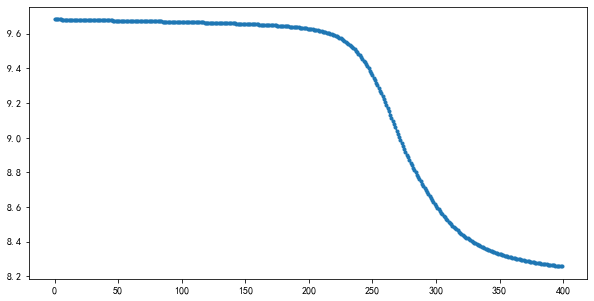

In [17]:
import matplotlib.pyplot as plt

# load previous loss
#with open(path+'loss_dict_train.pickle', 'rb') as f:
#    loss_dict_train = pickle.load(f)

# get loss dict
loss_dict_train = {}
loss_dict_train.update(loss_dict_)
# save loss dict
loss_dict_train_file = open(path+'loss_dict_train.pickle', 'wb')
pickle.dump(loss_dict_train, loss_dict_train_file)
loss_dict_train_file.close()
# paint
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(10,5))
plt.plot(list(loss_dict_train.keys()), list(loss_dict_train.values()),
        marker='.', label = "train_loss")
plt.show()